# Project

In [155]:
import numpy as np
import pandas as pd 
import math
from random import gauss
from math import sqrt
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from math import log, sqrt, exp
from scipy.stats import norm
from glob import glob
import warnings
import os
from functools import reduce
warnings.filterwarnings("ignore")

# Data Acquisition and Cleaning - 10 years daily from NASDAQ 100 Technology Sector 

In [37]:
# function for reading files
def read_file(f):
    df = pd.read_csv(f)
    df['ticker'] = f.split('.')[0].strip('^')
    return df

# function for getting log-returns
def getlogret(data):
    logret = np.log(data) - np.log(data.shift(1))
    return logret

In [38]:
# create the dataframe for closing price, named as 'close'
close = pd.concat([read_file(f) for f in glob('*.csv')])
close = close.set_index(['Date','ticker'])[['Close']].unstack()
# extract the tickers for renaming purpose later
tickers = close.columns.get_level_values('ticker')
#print(close)

In [39]:
# create the dataframe for logreturns, named as 'logret'
logret = close
for i in range(0,len(close.axes[1])):
    logret.iloc[:,i] = getlogret(close.iloc[:,i])
logret = logret.iloc[1:].rename(columns={'Close': 'Logret'})
#print(logret)

# Data Analysis - use the historical data to predict the future

In [40]:
# define functions for plotting histogram and the numerical results
# given the error functions and a fixed timewindow
def plothist(function, tw):
    myerr = function(logret, tw).iloc[1:]
    fig = plt.figure(figsize = (15,10))
    ax = fig.gca()
    errplot = myerr.hist(ax = ax)
    errvalue = print(myerr)
    return errvalue, errplot

## Volatility

In [41]:
# Define functions for actual/predicted volatility and the absolute error between them

def volpred(df, n):
    # keep the index for non-overlapped rolling window. eg for a=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], a[2::3]=[2, 5, 8]
    return df.rolling(n).std()[n-1::n] 

def volerr(df, n):
    df_volpred = volpred(df, n) 
    df_volerr = (df_volpred - df_volpred.shift(1)).rename(columns={'Logret': 'Residual Error (Volatility)'})
    return df_volerr

def volabserr(df, n):
    df_volpred = volpred(df, n)
    df_volabserr = (df_volpred - df_volpred.shift(1)).abs().rename(columns={'Logret': 'Absolute Error (Volatility)'})
    return df_volabserr

In [174]:
# Define error functions, relative errors, taking size of error into account

def volAPE(df,n): # use absolute percentage error
    df_volpred = volpred(df, n)
    df_volerr = (df_volpred - df_volpred.shift(1))
    df_volerr.columns = tickers
    df_volpred.columns = tickers
    df_volAPE = (df_volerr.iloc[1:].div(df_volpred.iloc[1:])).abs() # abs((actual-pred)/actual) 
    df_volAPE.columns=pd.MultiIndex.from_product([['APE (Volatility)'], df_volAPE.columns])
    return df_volAPE

def volAMPE(df,n): # use absolute mean percentage error
    df_volpred = volpred(df, n)
    df_volerr = (df_volpred - df_volpred.shift(1))
    df_volerr.columns = tickers
    df_volpred.columns = tickers
    avg = (df_volerr.iloc[1:] + df_volpred.iloc[1:]) / 2
    df_volAMPE = (df_volerr.iloc[1:].div(avg)).abs() # abs((actual-pred)/avg) 
    df_volAMPE.columns=pd.MultiIndex.from_product([['AMPE (Volatility)'], df_volAMPE.columns])
    return df_volAMPE

def volLAAR(df,n): # use log of absolute value of accuracy ratio as error
    df_volpred = volpred(df, n)
    df_volact = df_volpred.shift(1)
    df_volact.columns = tickers
    df_volpred.columns = tickers
    df_volLAAR = np.log(((df_volpred.iloc[1:].div(df_volact.iloc[1:]))).abs()) # log(abs(pred/act)) 
    df_volLAAR.columns=pd.MultiIndex.from_product([['LAAR (Volatility)'], df_volLAAR.columns])
    return df_volLAAR


### Iterate through the time window

In [142]:
# # define functions for printing the numerical results and plotting the dot graphs
# given the error functions, starting&ending timewindow with step size, tail
def plotdot_vol(function, tw1, tw2, step, tail):
    
    # create a NaN dataframe with rows as the time window, columns as the securities
    col_names = [i for i in range(tw1, tw2+step, step)] # timewindow
    # generate NaN entries
    data = np.empty((close.shape[1], len(col_names))) # number of rows = number of securities
    # create dataframe
    data[:] = np.nan
    dfnan = pd.DataFrame(data, columns=col_names)
    
    # fill in the NaN dataframe with the percentage of error observations in tail
    percent = dfnan
    j=0
    for i in range(tw1, tw2+step, step):
        myerr = (function(logret, i).iloc[1:])*np.sqrt(260) # use annual vol
        # create df 'outlier' consists of T/F, T if abs err>tail
        outlier = myerr > tail
        # fill in values representing the percentage of abs error outside tail
        # outlier.mean() calculates percentage of T values 
        percent.iloc[:,j] = outlier.mean().reset_index(drop=True) 
        j = j+1
    
    percent_T = percent.transpose() # exchange x and y axis for plotting purpose
    percent_T.columns = tickers # rename the columns as the securities
    dotvalue = print(percent_T)

    # plot the dot chart
    dotplot = percent_T.plot(ls = '', marker = '.', figsize = (10,5), title = f"Volatility, Percentage of error observations outside tail={tail}, {str(function.__name__).strip('vol')}")
    dotplot.legend(bbox_to_anchor = (1.2, 1))
    return dotvalue, dotplot

## Mean

In [49]:
# Define functions for actual/predicted mean and the absolute error between them

def meanpred(df, n):
    return df.rolling(n).mean()[n-1::n]

def meanerr(df, n):
    df_meanpred = meanpred(df, n)
    df_meanerr = (df_meanpred - df_meanpred.shift(1)).rename(columns={'Logret': 'Residual Error (Mean)'})
    return df_meanerr 

def meanabserr(df, n):
    df_meanpred = meanpred(df, n)
    df_meanabserr = (df_meanpred - df_meanpred.shift(1)).abs().rename(columns={'Logret': 'Absolute Error (Mean)'})
    return df_meanabserr

In [173]:
# Define error functions, relative errors, taking size of error into account

def meanAPE(df,n): # use absolute percentage error
    df_meanpred = meanpred(df, n)
    df_meanerr = (df_meanpred - df_meanpred.shift(1))
    df_meanerr.columns = tickers
    df_meanpred.columns = tickers
    df_meanAPE = (df_meanerr.iloc[1:].div(df_meanpred.iloc[1:])).abs() # abs((actual-pred)/actual)
    df_meanAPE.columns=pd.MultiIndex.from_product([['APE (Mean)'], df_meanAPE.columns])
    return df_meanAPE

def meanAMPE(df,n): # use absolute mean percentage error
    df_meanpred = meanpred(df, n)
    df_meanerr = (df_meanpred - df_meanpred.shift(1))
    df_meanerr.columns = tickers
    df_meanpred.columns = tickers
    avg = (df_meanerr.iloc[1:] + df_meanpred.iloc[1:]) / 2
    df_meanAMPE = (df_meanerr.iloc[1:].div(avg)).abs() # abs((actual-pred)/avg) 
    df_meanAMPE.columns=pd.MultiIndex.from_product([['AMPE (Mean)'], df_meanAMPE.columns])
    return df_meanAMPE

def meanLAAR(df,n): # use log of absolute value of accuracy ratio as error
    df_meanpred = meanpred(df, n)
    df_meanact = df_meanpred.shift(1)
    df_meanact.columns = tickers
    df_meanpred.columns = tickers
    df_meanLAAR = np.log((df_meanpred.iloc[1:].div(df_meanact.iloc[1:])).abs()) # log(abs((pred/act)))
    df_meanLAAR.columns=pd.MultiIndex.from_product([['LAAR (Mean)'], df_meanLAAR.columns])
    return df_meanLAAR

### Iterate through the time window

In [105]:
# # define functions for printing the numerical results and plotting the dot graphs
# given the error functions, starting&ending timewindow with step size, tail

def plotdot_mean(function, tw1, tw2, step, tail):
    
    # create a NaN dataframe with rows as the time window, columns as the securities
    col_names = [i for i in range(tw1, tw2+step, step)] # timewindow
    # generate NaN entries
    data = np.empty((close.shape[1], len(col_names))) # number of rows = number of securities
    # create dataframe
    data[:] = np.nan
    dfnan = pd.DataFrame(data, columns=col_names)
    
    # fill in the NaN dataframe with the percentage of error observations in tail
    percent = dfnan
    j=0
    for i in range(tw1, tw2+step, step):
        myerr = (function(logret, i).iloc[1:])*260 # use annual mean
        # create df 'outlier' consists of T/F, T if abs err>tail
        outlier = myerr > tail
        # fill in values representing the percentage of abs error outside tail
        # outlier.mean() calculates percentage of T values 
        percent.iloc[:,j] = outlier.mean().reset_index(drop=True) 
        j = j+1
    
    percent_T = percent.transpose()
    percent_T.columns = tickers # rename the columns as the securities
    dotvalue = print(percent_T)

    # plot the dot chart
    dotplot = percent_T.plot(ls = '', marker = '.', figsize = (10,5), title = f"Mean, Percentage of error observations outside tail={tail}, {str(function.__name__).strip('mean')}")
    dotplot.legend(bbox_to_anchor = (1.2, 1))
    return dotvalue, dotplot


## Compute results for volatility & mean

           AMPE (Volatility)                                              \
ticker                  AAPL        AMD      BIDU      GOOGL        IXIC   
Date                                                                       
2012-03-30          0.709059   9.771178  2.031628   0.311188    9.017819   
2012-07-11          0.472313   0.386161  0.204223   0.087982    0.503327   
2012-10-18          1.690172   0.302512  0.274050   0.019506    1.732826   
2013-02-01          0.657481   0.211697  0.291700   0.407116    0.173395   
2013-05-14          2.290193   0.614884  0.119132   0.214775    0.191624   
2013-08-22          0.558019   0.020764  0.039337   0.455259    0.184560   
2013-12-02          0.102149   0.610868  0.177119   0.623154    0.054455   
2014-03-14          0.021601   0.307449  0.135499   1.750588    0.144317   
2014-06-24          0.343581   0.000063  0.137980   0.348727    0.142631   
2014-10-02          0.173748   0.123700  0.223288   1.258267    0.720525   
2015-01-13  

(None,
 array([[<AxesSubplot:title={'center':"('AMPE (Volatility)', 'AAPL')"}>,
         <AxesSubplot:title={'center':"('AMPE (Volatility)', 'AMD')"}>,
         <AxesSubplot:title={'center':"('AMPE (Volatility)', 'BIDU')"}>],
        [<AxesSubplot:title={'center':"('AMPE (Volatility)', 'GOOGL')"}>,
         <AxesSubplot:title={'center':"('AMPE (Volatility)', 'IXIC')"}>,
         <AxesSubplot:title={'center':"('AMPE (Volatility)', 'MSFT')"}>],
        [<AxesSubplot:title={'center':"('AMPE (Volatility)', 'NDXT')"}>,
         <AxesSubplot:title={'center':"('AMPE (Volatility)', 'NVDA')"}>,
         <AxesSubplot:title={'center':"('AMPE (Volatility)', 'NXPI')"}>],
        [<AxesSubplot:title={'center':"('AMPE (Volatility)', 'QCOM')"}>,
         <AxesSubplot:title={'center':"('AMPE (Volatility)', 'SWKS')"}>,
         <AxesSubplot:title={'center':"('AMPE (Volatility)', 'TXN')"}>]],
       dtype=object))

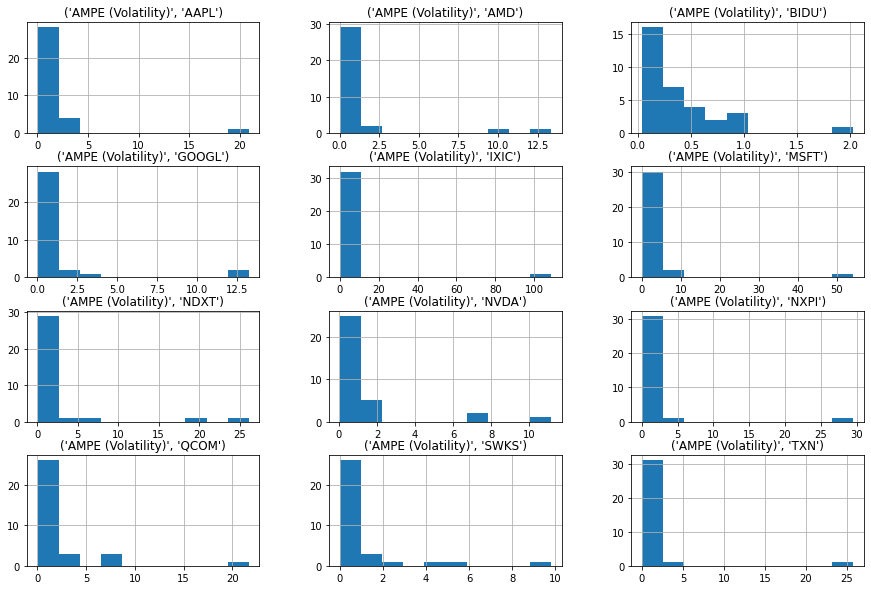

In [144]:
# Volatility, AMPE, histogram, time window=70
plothist(volAMPE, 70)

           AMPE (Volatility)                                              \
ticker                  AAPL        AMD      BIDU      GOOGL        IXIC   
Date                                                                       
2012-03-30          0.709059   9.771178  2.031628   0.311188    9.017819   
2012-07-11          0.472313   0.386161  0.204223   0.087982    0.503327   
2012-10-18          1.690172   0.302512  0.274050   0.019506    1.732826   
2013-02-01          0.657481   0.211697  0.291700   0.407116    0.173395   
2013-05-14          2.290193   0.614884  0.119132   0.214775    0.191624   
2013-08-22          0.558019   0.020764  0.039337   0.455259    0.184560   
2013-12-02          0.102149   0.610868  0.177119   0.623154    0.054455   
2014-03-14          0.021601   0.307449  0.135499   1.750588    0.144317   
2014-06-24          0.343581   0.000063  0.137980   0.348727    0.142631   
2014-10-02          0.173748   0.123700  0.223288   1.258267    0.720525   
2015-01-13  

(None,
 array([[<AxesSubplot:title={'center':"('AMPE (Volatility)', 'AAPL')"}>,
         <AxesSubplot:title={'center':"('AMPE (Volatility)', 'AMD')"}>,
         <AxesSubplot:title={'center':"('AMPE (Volatility)', 'BIDU')"}>],
        [<AxesSubplot:title={'center':"('AMPE (Volatility)', 'GOOGL')"}>,
         <AxesSubplot:title={'center':"('AMPE (Volatility)', 'IXIC')"}>,
         <AxesSubplot:title={'center':"('AMPE (Volatility)', 'MSFT')"}>],
        [<AxesSubplot:title={'center':"('AMPE (Volatility)', 'NDXT')"}>,
         <AxesSubplot:title={'center':"('AMPE (Volatility)', 'NVDA')"}>,
         <AxesSubplot:title={'center':"('AMPE (Volatility)', 'NXPI')"}>],
        [<AxesSubplot:title={'center':"('AMPE (Volatility)', 'QCOM')"}>,
         <AxesSubplot:title={'center':"('AMPE (Volatility)', 'SWKS')"}>,
         <AxesSubplot:title={'center':"('AMPE (Volatility)', 'TXN')"}>]],
       dtype=object))

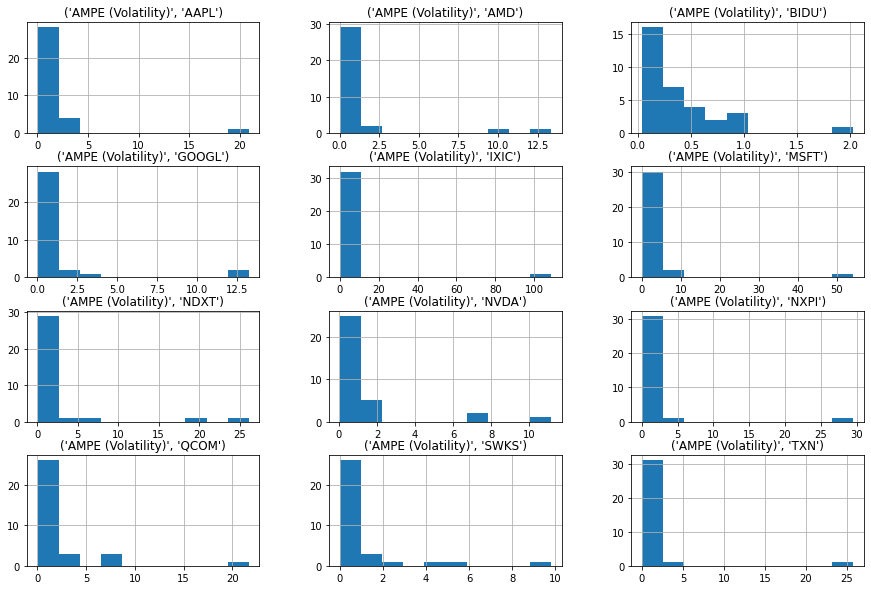

In [126]:
# Mean, AMPE, histogram, time window=70
plothist(volAMPE, 70)

ticker      AAPL       AMD      BIDU     GOOGL      IXIC      MSFT      NDXT  \
5       0.992016  0.982036  0.984032  0.980040  0.986028  0.974052  0.986028   
10      0.975904  0.979920  0.987952  0.971888  0.975904  0.971888  0.987952   
15      0.969697  0.981818  0.945455  0.987879  0.963636  0.975758  0.975758   
20      0.967480  0.975610  0.959350  0.975610  0.983740  0.959350  0.975610   
25      0.989796  0.979592  0.969388  0.979592  0.979592  0.989796  0.948980   
30      1.000000  1.000000  0.975309  0.987654  1.000000  0.987654  0.987654   
35      0.985507  1.000000  0.985507  0.985507  0.956522  0.942029  0.985507   
40      0.966667  0.983333  0.950000  1.000000  0.950000  1.000000  1.000000   
45      0.962264  0.981132  0.981132  0.962264  0.943396  0.943396  0.943396   
50      0.937500  0.958333  0.937500  0.979167  0.979167  0.937500  0.979167   
55      0.953488  0.976744  0.976744  0.976744  0.953488  0.976744  1.000000   
60      0.948718  0.948718  0.974359  0.

(None,
 <AxesSubplot:title={'center':'Volatility, Percentage of error observations outside tail=0.5, AMPE'}>)

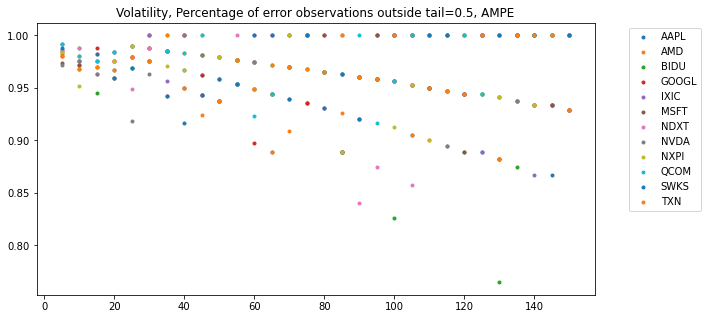

In [102]:
# Volatility, AMPE, time window from 5 to 150, step size 5, tail 50%
plotdot_vol(volAMPE, 5, 150, 5, 0.5)

ticker      AAPL       AMD      BIDU     GOOGL      IXIC      MSFT      NDXT  \
5       1.000000  0.994012  0.998004  0.994012  0.998004  0.994012  0.998004   
10      0.995984  1.000000  0.995984  0.987952  0.995984  0.983936  0.995984   
15      1.000000  0.993939  0.987879  1.000000  0.993939  1.000000  0.993939   
20      0.991870  1.000000  0.983740  0.983740  1.000000  0.983740  1.000000   
25      1.000000  0.989796  1.000000  1.000000  1.000000  1.000000  0.979592   
30      1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
35      0.985507  1.000000  1.000000  0.985507  1.000000  0.985507  1.000000   
40      1.000000  1.000000  1.000000  1.000000  0.966667  1.000000  1.000000   
45      1.000000  1.000000  1.000000  0.981132  1.000000  1.000000  0.981132   
50      1.000000  1.000000  0.979167  1.000000  1.000000  0.958333  1.000000   
55      1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
60      0.974359  1.000000  1.000000  1.

(None,
 <AxesSubplot:title={'center':'Volatility, Percentage of error observations outside tail=0.1, AMPE'}>)

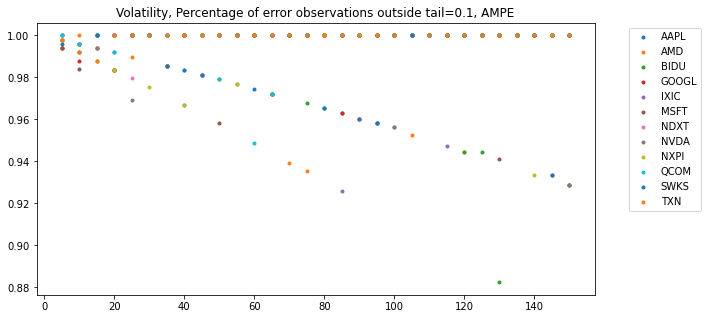

In [103]:
# Volatility, AMPE, time window from 5 to 150, step size 5, tail 10%
plotdot_vol(volAMPE, 5, 150, 5, 0.1)

ticker  AAPL  AMD  BIDU  GOOGL  IXIC  MSFT  NDXT  NVDA  NXPI  QCOM  SWKS  TXN
5        1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
10       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
15       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
20       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
25       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
30       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
35       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
40       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
45       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
50       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
55       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
60       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1

(None,
 <AxesSubplot:title={'center':'Volatility, Percentage of error observations outside tail=0, AMPE'}>)

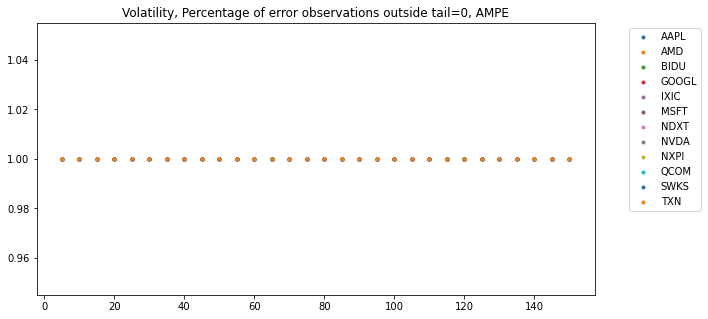

In [104]:
# Volatility, AMPE, time window from 5 to 150, step size 5, tail 0
plotdot_vol(volAMPE, 5, 150, 5, 0)

ticker  AAPL       AMD  BIDU  GOOGL      IXIC     MSFT  NDXT      NVDA  NXPI  \
5        1.0  0.998004   1.0    1.0  0.992016  1.00000   1.0  0.998004   1.0   
10       1.0  1.000000   1.0    1.0  1.000000  1.00000   1.0  1.000000   1.0   
15       1.0  0.993939   1.0    1.0  1.000000  1.00000   1.0  1.000000   1.0   
20       1.0  1.000000   1.0    1.0  1.000000  0.99187   1.0  1.000000   1.0   
25       1.0  1.000000   1.0    1.0  1.000000  1.00000   1.0  1.000000   1.0   
30       1.0  1.000000   1.0    1.0  1.000000  1.00000   1.0  1.000000   1.0   
35       1.0  1.000000   1.0    1.0  1.000000  1.00000   1.0  1.000000   1.0   
40       1.0  1.000000   1.0    1.0  1.000000  1.00000   1.0  1.000000   1.0   
45       1.0  1.000000   1.0    1.0  1.000000  1.00000   1.0  1.000000   1.0   
50       1.0  1.000000   1.0    1.0  1.000000  1.00000   1.0  1.000000   1.0   
55       1.0  1.000000   1.0    1.0  1.000000  1.00000   1.0  0.976744   1.0   
60       1.0  1.000000   1.0    1.0  1.0

(None,
 <AxesSubplot:title={'center':'Mean, Percentage of error observations outside tail=0.5, AMPE'}>)

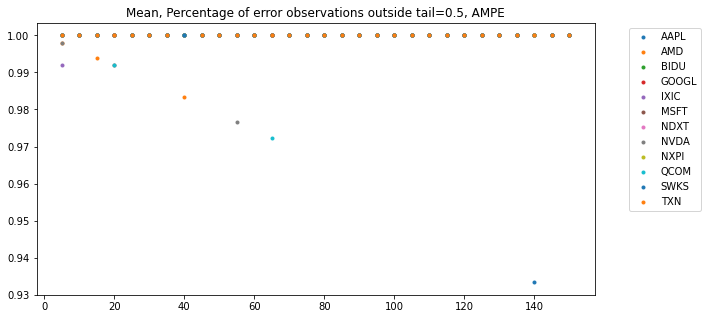

In [109]:
# Mean, AMPE, time window from 5 to 150, step size 5, tail 50%
plotdot_mean(meanAMPE, 5, 150, 5, 0.5)

ticker  AAPL       AMD  BIDU  GOOGL  IXIC  MSFT  NDXT      NVDA  NXPI  \
5        1.0  1.000000   1.0    1.0   1.0   1.0   1.0  0.998004   1.0   
10       1.0  1.000000   1.0    1.0   1.0   1.0   1.0  1.000000   1.0   
15       1.0  0.993939   1.0    1.0   1.0   1.0   1.0  1.000000   1.0   
20       1.0  1.000000   1.0    1.0   1.0   1.0   1.0  1.000000   1.0   
25       1.0  1.000000   1.0    1.0   1.0   1.0   1.0  1.000000   1.0   
30       1.0  1.000000   1.0    1.0   1.0   1.0   1.0  1.000000   1.0   
35       1.0  1.000000   1.0    1.0   1.0   1.0   1.0  1.000000   1.0   
40       1.0  1.000000   1.0    1.0   1.0   1.0   1.0  1.000000   1.0   
45       1.0  1.000000   1.0    1.0   1.0   1.0   1.0  1.000000   1.0   
50       1.0  1.000000   1.0    1.0   1.0   1.0   1.0  1.000000   1.0   
55       1.0  1.000000   1.0    1.0   1.0   1.0   1.0  1.000000   1.0   
60       1.0  1.000000   1.0    1.0   1.0   1.0   1.0  1.000000   1.0   
65       1.0  1.000000   1.0    1.0   1.0   1.0   1

(None,
 <AxesSubplot:title={'center':'Mean, Percentage of error observations outside tail=0.1, AMPE'}>)

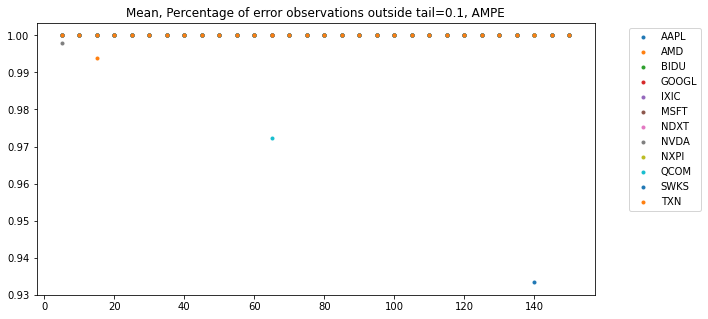

In [110]:
# Mean, AMPE, time window from 5 to 150, step size 5, tail 10%
plotdot_mean(meanAMPE, 5, 150, 5, 0.1)

ticker  AAPL       AMD  BIDU  GOOGL  IXIC  MSFT  NDXT  NVDA  NXPI  QCOM  SWKS  \
5        1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
10       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
15       1.0  0.993939   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
20       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
25       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
30       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
35       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
40       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
45       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
50       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
55       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
60       1.0  1.000000   1.0

(None,
 <AxesSubplot:title={'center':'Mean, Percentage of error observations outside tail=0, AMPE'}>)

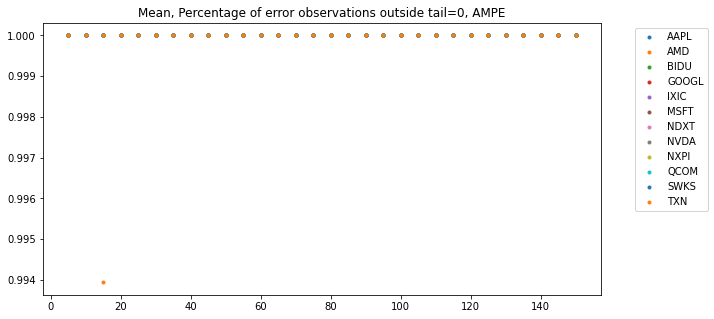

In [111]:
# Mean, AMPE, time window from 5 to 150, step size 5, tail 0%
plotdot_mean(meanAMPE, 5, 150, 5, 0)

           APE (Volatility)                                                    \
ticker                 AAPL       AMD      BIDU     GOOGL      IXIC      MSFT   
Date                                                                            
2012-03-30         0.261736  0.830093  0.503922  0.134644  1.284989  0.293238   
2012-07-11         0.309169  0.239281  0.092651  0.042137  0.336297  0.165205   
2012-10-18         0.458020  0.178211  0.158782  0.009849  0.464213  0.278649   
2013-02-01         0.489737  0.118379  0.127285  0.169130  0.094927  0.177406   
2013-05-14         0.533820  0.235148  0.063339  0.096974  0.087435  0.064764   
2013-08-22         0.218145  0.010491  0.020063  0.185422  0.084484  0.323507   
2013-12-02         0.053824  0.233971  0.081355  0.452595  0.027990  0.109660   
2014-03-14         0.010685  0.133242  0.072673  0.466750  0.077770  0.354638   
2014-06-24         0.146605  0.000032  0.064537  0.211187  0.076792  0.073947   
2014-10-02         0.079930 

(None,
 array([[<AxesSubplot:title={'center':"('APE (Volatility)', 'AAPL')"}>,
         <AxesSubplot:title={'center':"('APE (Volatility)', 'AMD')"}>,
         <AxesSubplot:title={'center':"('APE (Volatility)', 'BIDU')"}>],
        [<AxesSubplot:title={'center':"('APE (Volatility)', 'GOOGL')"}>,
         <AxesSubplot:title={'center':"('APE (Volatility)', 'IXIC')"}>,
         <AxesSubplot:title={'center':"('APE (Volatility)', 'MSFT')"}>],
        [<AxesSubplot:title={'center':"('APE (Volatility)', 'NDXT')"}>,
         <AxesSubplot:title={'center':"('APE (Volatility)', 'NVDA')"}>,
         <AxesSubplot:title={'center':"('APE (Volatility)', 'NXPI')"}>],
        [<AxesSubplot:title={'center':"('APE (Volatility)', 'QCOM')"}>,
         <AxesSubplot:title={'center':"('APE (Volatility)', 'SWKS')"}>,
         <AxesSubplot:title={'center':"('APE (Volatility)', 'TXN')"}>]],
       dtype=object))

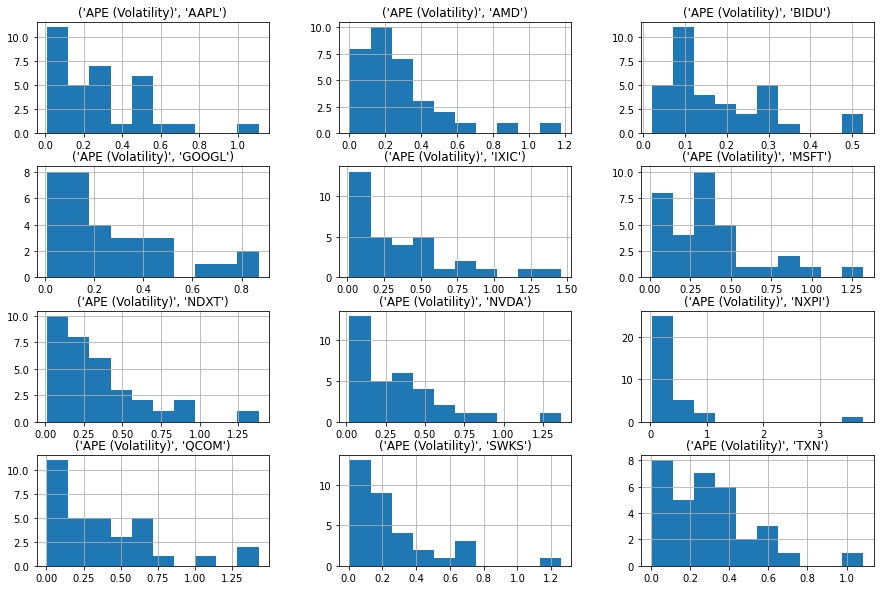

In [127]:
# Volatility, APE, histogram, time window=70
plothist(volAPE, 70)

           APE (Mean)                                                \
ticker           AAPL           AMD      BIDU      GOOGL       IXIC   
Date                                                                  
2012-03-30   0.972340  1.586616e+00  1.944909   4.516278   0.891226   
2012-07-11  54.536783  2.012438e+00  1.921204   1.265703   3.982525   
2012-10-18   0.822287  2.071605e-01  8.595730   1.589642   2.097769   
2013-02-01   1.137132  8.043395e+01  1.930848   0.788012   0.825883   
2013-05-14  14.293437  1.015519e+00  0.737287   0.183111   0.602150   
2013-08-22   1.174003  4.085282e+00  1.385021   9.831558   0.722041   
2013-12-02   0.364024  2.044433e+01  1.149876   1.080876   0.531645   
2014-03-14   2.857179  8.373741e-01  4.865637   0.768321   1.193336   
2014-06-24   1.265267  1.190191e+00  1.406245   5.267491   0.977461   
2014-10-02   0.837151  1.153691e+00  0.290721   2.723187   0.342627   
2015-01-13   0.029957  3.800064e-01  6.699475   1.098820   0.642610   
2015-0

(None,
 array([[<AxesSubplot:title={'center':"('APE (Mean)', 'AAPL')"}>,
         <AxesSubplot:title={'center':"('APE (Mean)', 'AMD')"}>,
         <AxesSubplot:title={'center':"('APE (Mean)', 'BIDU')"}>],
        [<AxesSubplot:title={'center':"('APE (Mean)', 'GOOGL')"}>,
         <AxesSubplot:title={'center':"('APE (Mean)', 'IXIC')"}>,
         <AxesSubplot:title={'center':"('APE (Mean)', 'MSFT')"}>],
        [<AxesSubplot:title={'center':"('APE (Mean)', 'NDXT')"}>,
         <AxesSubplot:title={'center':"('APE (Mean)', 'NVDA')"}>,
         <AxesSubplot:title={'center':"('APE (Mean)', 'NXPI')"}>],
        [<AxesSubplot:title={'center':"('APE (Mean)', 'QCOM')"}>,
         <AxesSubplot:title={'center':"('APE (Mean)', 'SWKS')"}>,
         <AxesSubplot:title={'center':"('APE (Mean)', 'TXN')"}>]],
       dtype=object))

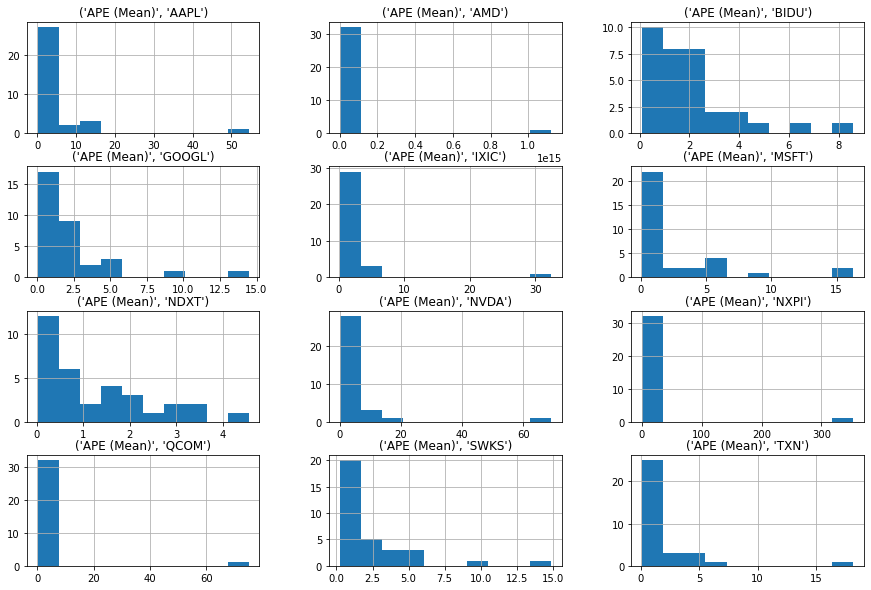

In [128]:
# Mean, APE, histogram, time window=70
plothist(meanAPE, 70)

ticker      AAPL       AMD      BIDU     GOOGL      IXIC      MSFT      NDXT  \
5       0.976048  0.972056  0.968064  0.972056  0.970060  0.958084  0.968064   
10      0.963855  0.967871  0.943775  0.955823  0.951807  0.955823  0.943775   
15      0.945455  0.945455  0.921212  0.981818  0.951515  0.957576  0.945455   
20      0.951220  0.951220  0.918699  0.943089  0.967480  0.943089  0.926829   
25      0.989796  0.928571  0.948980  0.969388  0.959184  0.918367  0.938776   
30      0.975309  0.987654  0.925926  0.975309  0.975309  0.962963  0.962963   
35      0.956522  0.971014  0.927536  0.971014  0.913043  0.927536  0.927536   
40      0.916667  0.966667  0.933333  0.916667  0.933333  0.966667  0.950000   
45      0.962264  0.924528  0.962264  0.924528  0.849057  0.905660  0.924528   
50      0.916667  0.937500  0.895833  0.937500  0.937500  0.875000  0.958333   
55      0.906977  0.976744  0.906977  0.906977  0.930233  0.953488  0.953488   
60      0.923077  0.948718  0.923077  0.

(None,
 <AxesSubplot:title={'center':'Volatility, Percentage of error observations outside tail=0.5, APE'}>)

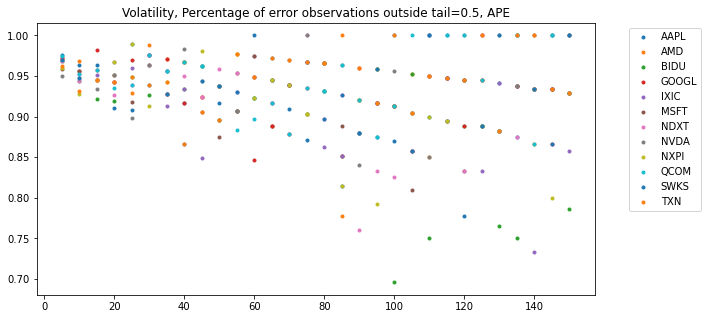

In [130]:
# Mean, APE, time window from 5 to 150, step size 5, tail 50%
plotdot_vol(volAPE, 5, 150, 5, 0.5)

ticker      AAPL       AMD      BIDU     GOOGL      IXIC      MSFT      NDXT  \
5       0.998004  0.994012  0.994012  0.990020  0.996008  0.988024  0.994012   
10      0.991968  1.000000  0.995984  0.979920  0.991968  0.979920  0.995984   
15      1.000000  0.993939  0.951515  1.000000  0.993939  0.987879  0.993939   
20      0.991870  1.000000  0.983740  0.983740  0.991870  0.967480  1.000000   
25      1.000000  0.989796  1.000000  1.000000  0.979592  1.000000  0.969388   
30      1.000000  1.000000  1.000000  0.987654  1.000000  1.000000  1.000000   
35      0.985507  1.000000  1.000000  0.985507  1.000000  0.985507  0.985507   
40      1.000000  1.000000  0.966667  1.000000  0.966667  1.000000  1.000000   
45      1.000000  0.981132  1.000000  0.981132  0.981132  1.000000  0.962264   
50      0.979167  0.979167  0.979167  1.000000  1.000000  0.958333  0.979167   
55      0.976744  1.000000  0.976744  1.000000  0.976744  1.000000  1.000000   
60      0.974359  1.000000  0.974359  0.

(None,
 <AxesSubplot:title={'center':'Volatility, Percentage of error observations outside tail=0.1, APE'}>)

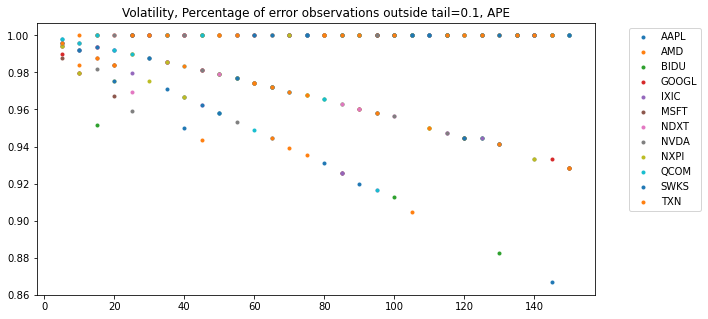

In [131]:
# Mean, APE, time window from 5 to 150, step size 5, tail 10%
plotdot_vol(volAPE, 5, 150, 5, 0.1)

ticker  AAPL  AMD  BIDU  GOOGL  IXIC  MSFT  NDXT  NVDA  NXPI  QCOM  SWKS  TXN
5        1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
10       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
15       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
20       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
25       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
30       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
35       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
40       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
45       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
50       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
55       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  1.0
60       1.0  1.0   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1

(None,
 <AxesSubplot:title={'center':'Volatility, Percentage of error observations outside tail=0, APE'}>)

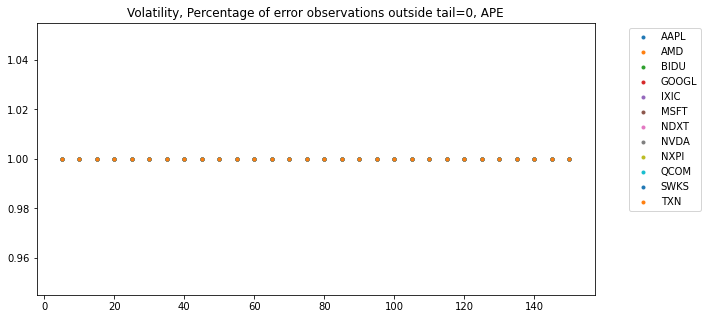

In [132]:
# Mean, APE, time window from 5 to 150, step size 5, tail 0
plotdot_vol(volAPE, 5, 150, 5, 0)

ticker      AAPL       AMD  BIDU     GOOGL      IXIC      MSFT  NDXT  \
5       1.000000  0.998004   1.0  1.000000  0.992016  1.000000   1.0   
10      0.995984  1.000000   1.0  1.000000  1.000000  0.995984   1.0   
15      1.000000  0.993939   1.0  1.000000  1.000000  1.000000   1.0   
20      1.000000  1.000000   1.0  1.000000  1.000000  0.991870   1.0   
25      1.000000  1.000000   1.0  1.000000  1.000000  1.000000   1.0   
30      1.000000  0.987654   1.0  1.000000  1.000000  1.000000   1.0   
35      1.000000  1.000000   1.0  1.000000  1.000000  1.000000   1.0   
40      1.000000  0.983333   1.0  1.000000  1.000000  1.000000   1.0   
45      1.000000  1.000000   1.0  1.000000  1.000000  1.000000   1.0   
50      1.000000  1.000000   1.0  1.000000  1.000000  1.000000   1.0   
55      1.000000  1.000000   1.0  1.000000  1.000000  1.000000   1.0   
60      1.000000  1.000000   1.0  0.974359  1.000000  1.000000   1.0   
65      1.000000  1.000000   1.0  1.000000  1.000000  1.000000  

(None,
 <AxesSubplot:title={'center':'Mean, Percentage of error observations outside tail=0.5, APE'}>)

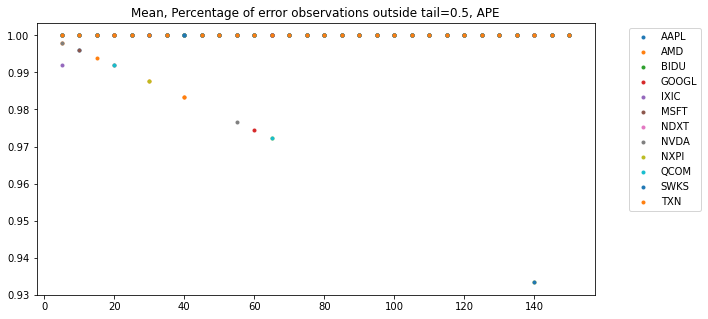

In [133]:
# Mean, APE, time window from 5 to 150, step size 5, tail 50%
plotdot_mean(meanAPE, 5, 150, 5, 0.5)

ticker  AAPL       AMD  BIDU  GOOGL  IXIC  MSFT  NDXT      NVDA  NXPI  \
5        1.0  0.998004   1.0    1.0   1.0   1.0   1.0  0.998004   1.0   
10       1.0  1.000000   1.0    1.0   1.0   1.0   1.0  1.000000   1.0   
15       1.0  0.993939   1.0    1.0   1.0   1.0   1.0  1.000000   1.0   
20       1.0  1.000000   1.0    1.0   1.0   1.0   1.0  1.000000   1.0   
25       1.0  1.000000   1.0    1.0   1.0   1.0   1.0  1.000000   1.0   
30       1.0  1.000000   1.0    1.0   1.0   1.0   1.0  1.000000   1.0   
35       1.0  1.000000   1.0    1.0   1.0   1.0   1.0  1.000000   1.0   
40       1.0  1.000000   1.0    1.0   1.0   1.0   1.0  1.000000   1.0   
45       1.0  1.000000   1.0    1.0   1.0   1.0   1.0  1.000000   1.0   
50       1.0  1.000000   1.0    1.0   1.0   1.0   1.0  1.000000   1.0   
55       1.0  1.000000   1.0    1.0   1.0   1.0   1.0  0.976744   1.0   
60       1.0  1.000000   1.0    1.0   1.0   1.0   1.0  1.000000   1.0   
65       1.0  1.000000   1.0    1.0   1.0   1.0   1

(None,
 <AxesSubplot:title={'center':'Mean, Percentage of error observations outside tail=0.1, APE'}>)

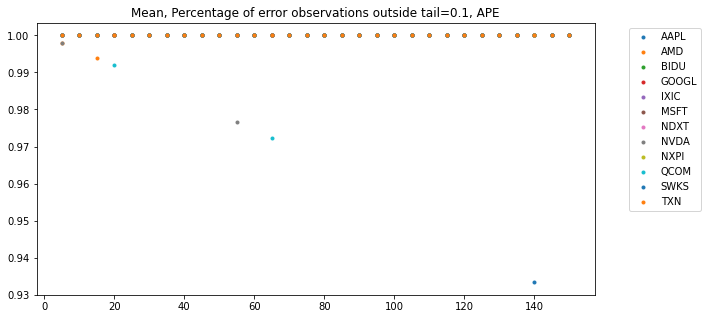

In [134]:
# Mean, APE, time window from 5 to 150, step size 5, tail 10%
plotdot_mean(meanAPE, 5, 150, 5, 0.1)

ticker  AAPL       AMD  BIDU  GOOGL  IXIC  MSFT  NDXT  NVDA  NXPI  QCOM  SWKS  \
5        1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
10       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
15       1.0  0.993939   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
20       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
25       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
30       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
35       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
40       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
45       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
50       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
55       1.0  1.000000   1.0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
60       1.0  1.000000   1.0

(None,
 <AxesSubplot:title={'center':'Mean, Percentage of error observations outside tail=0, APE'}>)

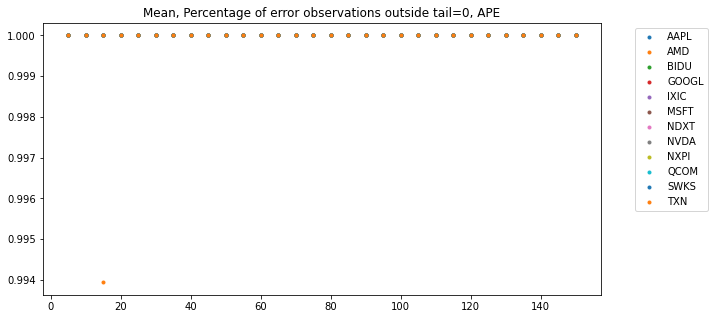

In [138]:
# Mean, APE, time window from 5 to 150, step size 5, tail 0
plotdot_mean(meanAPE, 5, 150, 5, 0)

           LAAR (Volatility)                                          \
ticker                  AAPL       AMD      BIDU     GOOGL      IXIC   
Date                                                                   
2012-03-30         -0.232489 -0.604367 -0.408077 -0.126319 -0.826361   
2012-07-11          0.369859  0.273491 -0.088607 -0.041274  0.409921   
2012-10-18         -0.377079  0.196272  0.172905  0.009898 -0.381318   
2013-02-01          0.672828  0.125993 -0.119812 -0.156260  0.099740   
2013-05-14         -0.427762 -0.211191  0.065434 -0.092555 -0.083821   
2013-08-22         -0.197329  0.010546  0.020267 -0.170099 -0.081104   
2013-12-02          0.055326 -0.210238 -0.078215  0.602567  0.028389   
2014-03-14         -0.010629 -0.125083  0.075449 -0.383049  0.080961   
2014-06-24         -0.136805 -0.000032 -0.062540  0.237226  0.079901   
2014-10-02         -0.076896  0.068202 -0.095702 -0.326549 -0.234952   
2015-01-13          0.121979 -0.092584 -0.072344  0.154350  0.33

(None,
 array([[<AxesSubplot:title={'center':"('LAAR (Volatility)', 'AAPL')"}>,
         <AxesSubplot:title={'center':"('LAAR (Volatility)', 'AMD')"}>,
         <AxesSubplot:title={'center':"('LAAR (Volatility)', 'BIDU')"}>],
        [<AxesSubplot:title={'center':"('LAAR (Volatility)', 'GOOGL')"}>,
         <AxesSubplot:title={'center':"('LAAR (Volatility)', 'IXIC')"}>,
         <AxesSubplot:title={'center':"('LAAR (Volatility)', 'MSFT')"}>],
        [<AxesSubplot:title={'center':"('LAAR (Volatility)', 'NDXT')"}>,
         <AxesSubplot:title={'center':"('LAAR (Volatility)', 'NVDA')"}>,
         <AxesSubplot:title={'center':"('LAAR (Volatility)', 'NXPI')"}>],
        [<AxesSubplot:title={'center':"('LAAR (Volatility)', 'QCOM')"}>,
         <AxesSubplot:title={'center':"('LAAR (Volatility)', 'SWKS')"}>,
         <AxesSubplot:title={'center':"('LAAR (Volatility)', 'TXN')"}>]],
       dtype=object))

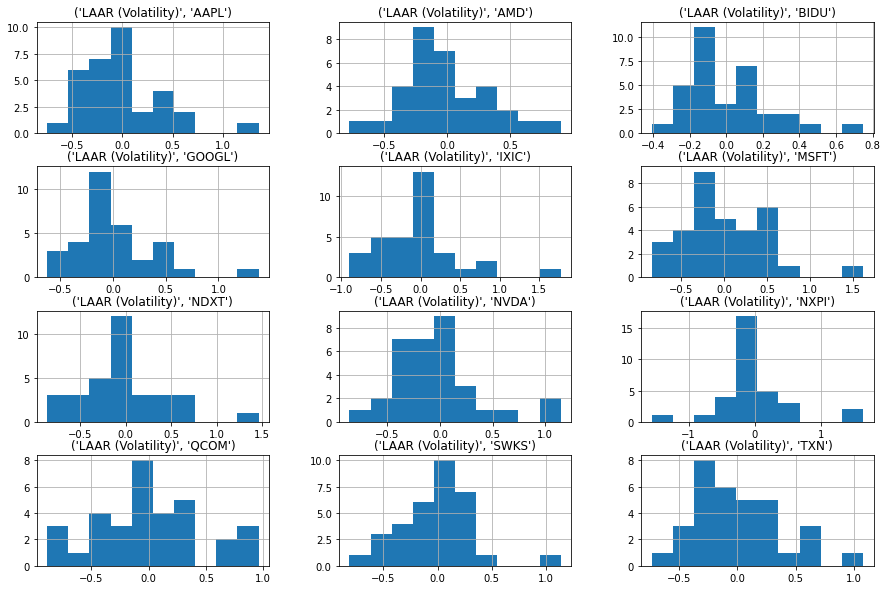

In [175]:
# Volatility, LAAR, histogram, time window=70
plothist(volLAAR, 70)

           LAAR (Mean)                                                     \
ticker            AAPL        AMD      BIDU     GOOGL      IXIC      MSFT   
Date                                                                        
2012-03-30    3.587786   0.533385  0.056667 -1.707703  2.218487  3.352059   
2012-07-11   -4.017046  -0.012362  0.082074  1.325374 -1.092770 -0.888358   
2012-10-18    1.727585   0.232134 -2.027586  0.528239 -0.093280 -2.649519   
2013-02-01    1.986815  -4.399792  0.071659 -0.581104 -0.602064  2.084329   
2013-05-14   -2.727424   4.165658  1.336693  0.202252  0.921680  1.206399   
2013-08-22    1.748683  -1.126643  0.954457 -2.178331 -0.543510 -1.664471   
2013-12-02   -0.310439  -2.967555 -0.765410  2.514833  0.758529  1.601047   
2014-03-14   -0.619059   1.816303 -1.352127 -0.570031 -0.785424 -2.164088   
2014-06-24    1.327019  -0.783989  0.900800 -1.451026 -0.681814  1.644811   
2014-10-02   -0.608216   1.872811  0.343507 -0.544175 -0.294628 -0.106718   

(None,
 array([[<AxesSubplot:title={'center':"('LAAR (Mean)', 'AAPL')"}>,
         <AxesSubplot:title={'center':"('LAAR (Mean)', 'AMD')"}>,
         <AxesSubplot:title={'center':"('LAAR (Mean)', 'BIDU')"}>],
        [<AxesSubplot:title={'center':"('LAAR (Mean)', 'GOOGL')"}>,
         <AxesSubplot:title={'center':"('LAAR (Mean)', 'IXIC')"}>,
         <AxesSubplot:title={'center':"('LAAR (Mean)', 'MSFT')"}>],
        [<AxesSubplot:title={'center':"('LAAR (Mean)', 'NDXT')"}>,
         <AxesSubplot:title={'center':"('LAAR (Mean)', 'NVDA')"}>,
         <AxesSubplot:title={'center':"('LAAR (Mean)', 'NXPI')"}>],
        [<AxesSubplot:title={'center':"('LAAR (Mean)', 'QCOM')"}>,
         <AxesSubplot:title={'center':"('LAAR (Mean)', 'SWKS')"}>,
         <AxesSubplot:title={'center':"('LAAR (Mean)', 'TXN')"}>]],
       dtype=object))

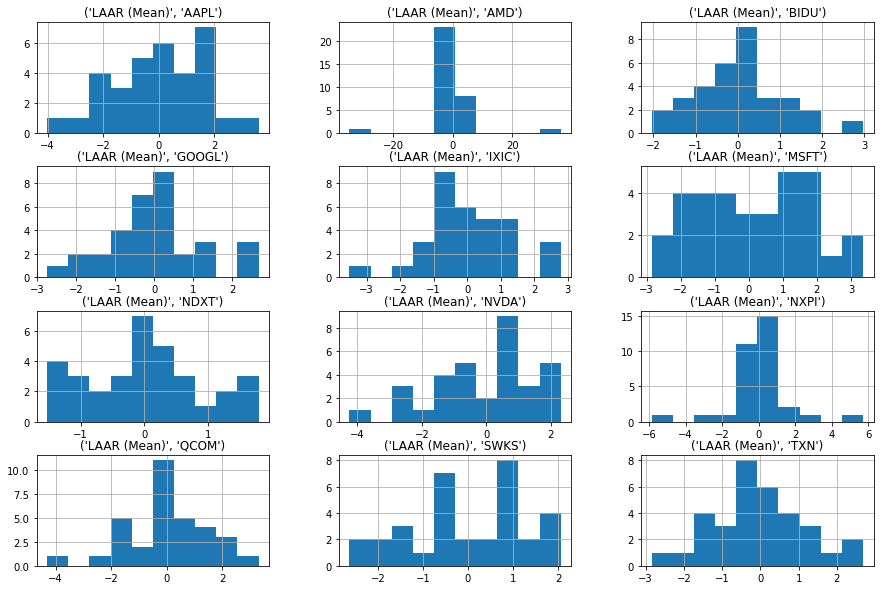

In [176]:
# mean, ALAR, histogram, time window=70
plothist(meanLAAR, 70)

ticker      AAPL       AMD      BIDU     GOOGL      IXIC      MSFT      NDXT  \
5       0.457086  0.431138  0.421158  0.459082  0.439122  0.413174  0.433134   
10      0.417671  0.433735  0.409639  0.421687  0.441767  0.409639  0.417671   
15      0.400000  0.466667  0.363636  0.400000  0.430303  0.424242  0.418182   
20      0.422764  0.463415  0.357724  0.333333  0.430894  0.414634  0.390244   
25      0.408163  0.428571  0.357143  0.377551  0.367347  0.367347  0.367347   
30      0.419753  0.407407  0.370370  0.395062  0.407407  0.407407  0.382716   
35      0.420290  0.391304  0.347826  0.391304  0.391304  0.376812  0.362319   
40      0.416667  0.433333  0.333333  0.333333  0.383333  0.283333  0.350000   
45      0.377358  0.433962  0.339623  0.301887  0.339623  0.339623  0.358491   
50      0.354167  0.395833  0.250000  0.416667  0.375000  0.375000  0.416667   
55      0.372093  0.395349  0.348837  0.372093  0.372093  0.348837  0.325581   
60      0.358974  0.358974  0.256410  0.

(None,
 <AxesSubplot:title={'center':'Volatility, Percentage of error observations outside tail=1.6487212707001282, LAAR'}>)

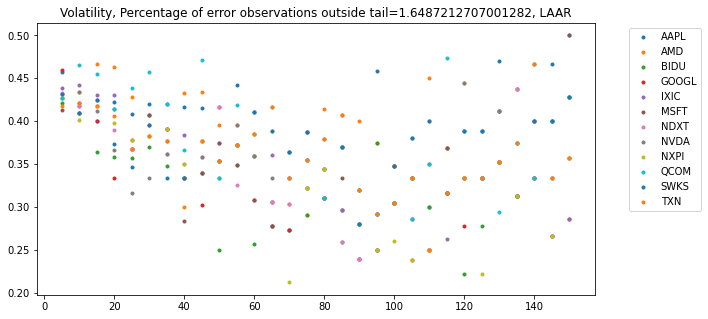

In [177]:
# Volatility, LAAR, time window from 5 to 150, step size 5, tail 1.65 (e^0.5)
plotdot_vol(volLAAR, 5, 150, 5, math.e**0.5)

ticker      AAPL       AMD      BIDU     GOOGL      IXIC      MSFT      NDXT  \
5       0.415170  0.409182  0.403194  0.399202  0.407186  0.381238  0.391218   
10      0.385542  0.401606  0.377510  0.377510  0.393574  0.365462  0.365462   
15      0.375758  0.430303  0.309091  0.363636  0.400000  0.387879  0.363636   
20      0.414634  0.422764  0.317073  0.325203  0.382114  0.373984  0.341463   
25      0.367347  0.387755  0.326531  0.346939  0.285714  0.306122  0.326531   
30      0.395062  0.382716  0.296296  0.345679  0.333333  0.358025  0.333333   
35      0.347826  0.347826  0.260870  0.347826  0.318841  0.333333  0.333333   
40      0.366667  0.383333  0.283333  0.283333  0.333333  0.283333  0.266667   
45      0.320755  0.377358  0.301887  0.245283  0.301887  0.301887  0.301887   
50      0.333333  0.395833  0.250000  0.312500  0.333333  0.354167  0.354167   
55      0.372093  0.348837  0.279070  0.255814  0.325581  0.348837  0.325581   
60      0.333333  0.307692  0.256410  0.

(None,
 <AxesSubplot:title={'center':'Volatility, Percentage of error observations outside tail=2.4596031111569494, LAAR'}>)

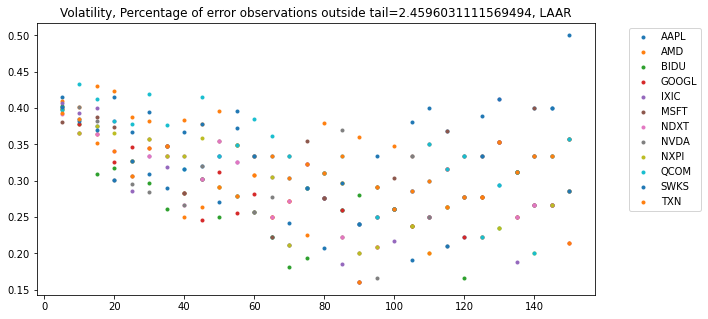

In [179]:
# Volatility, LAAR, time window from 5 to 150, step size 5, tail e^0.9
plotdot_vol(volLAAR, 5, 150, 5, math.e**0.9)

ticker  AAPL  AMD  BIDU  GOOGL  IXIC  MSFT  NDXT  NVDA  NXPI  QCOM  SWKS  TXN
5        0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
10       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
15       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
20       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
25       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
30       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
35       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
40       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
45       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
50       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
55       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
60       0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0

(None,
 <AxesSubplot:title={'center':'Volatility, Percentage of error observations outside tail=2.6881171418161212e+43, LAAR'}>)

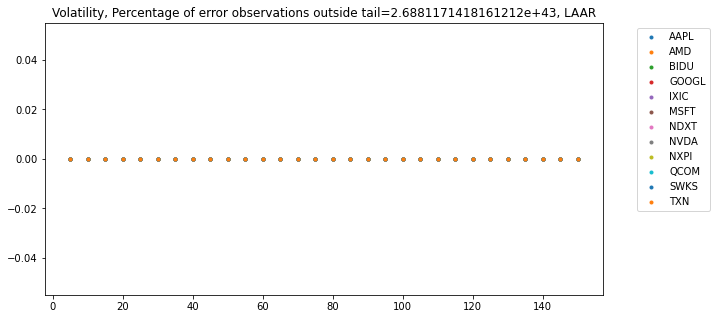

In [186]:
# Volatility, LAAR, time window from 5 to 150, step size 5, tail e^100
plotdot_vol(volLAAR, 5, 150, 5, math.e**100)

ticker      AAPL       AMD      BIDU     GOOGL      IXIC      MSFT      NDXT  \
5       0.499002  0.461078  0.457086  0.500998  0.485030  0.473054  0.481038   
10      0.497992  0.493976  0.477912  0.497992  0.485944  0.465863  0.473896   
15      0.496970  0.503030  0.442424  0.460606  0.472727  0.472727  0.478788   
20      0.471545  0.512195  0.430894  0.382114  0.487805  0.495935  0.471545   
25      0.469388  0.448980  0.418367  0.418367  0.438776  0.438776  0.387755   
30      0.530864  0.432099  0.432099  0.444444  0.469136  0.432099  0.456790   
35      0.536232  0.420290  0.449275  0.449275  0.449275  0.391304  0.449275   
40      0.466667  0.450000  0.400000  0.400000  0.466667  0.400000  0.483333   
45      0.433962  0.471698  0.452830  0.339623  0.415094  0.358491  0.433962   
50      0.416667  0.416667  0.375000  0.479167  0.479167  0.416667  0.479167   
55      0.441860  0.465116  0.488372  0.465116  0.441860  0.418605  0.372093   
60      0.435897  0.410256  0.435897  0.

(None,
 <AxesSubplot:title={'center':'Volatility, Percentage of error observations outside tail=0.36787944117144233, LAAR'}>)

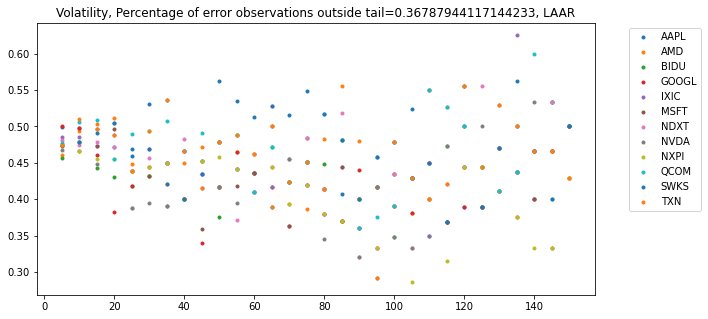

In [187]:
# Volatility, LAAR, time window from 5 to 150, step size 5, tail e^-1
plotdot_vol(volLAAR, 5, 150, 5, math.e**-1)

ticker      AAPL       AMD      BIDU     GOOGL      IXIC      MSFT      NDXT  \
5       0.504990  0.499002  0.518962  0.512974  0.493014  0.497006  0.500998   
10      0.485944  0.518072  0.485944  0.514056  0.473896  0.481928  0.481928   
15      0.521212  0.533333  0.490909  0.521212  0.503030  0.509091  0.454545   
20      0.479675  0.512195  0.552846  0.536585  0.447154  0.471545  0.495935   
25      0.530612  0.510204  0.510204  0.510204  0.540816  0.561224  0.500000   
30      0.543210  0.456790  0.481481  0.469136  0.481481  0.506173  0.493827   
35      0.521739  0.492754  0.449275  0.507246  0.507246  0.550725  0.507246   
40      0.500000  0.516667  0.466667  0.466667  0.500000  0.516667  0.483333   
45      0.471698  0.509434  0.490566  0.490566  0.547170  0.547170  0.509434   
50      0.520833  0.520833  0.479167  0.458333  0.458333  0.541667  0.479167   
55      0.488372  0.558140  0.534884  0.511628  0.488372  0.488372  0.534884   
60      0.384615  0.461538  0.487179  0.

(None,
 <AxesSubplot:title={'center':'Mean, Percentage of error observations outside tail=1.6487212707001282, LAAR'}>)

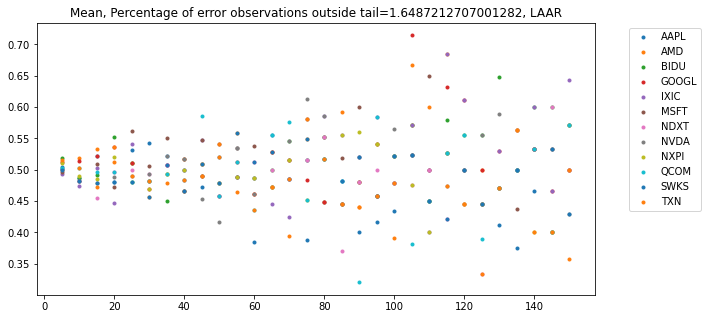

In [188]:
# Mean, LAAR, time window from 5 to 150, step size 5, tail e^0.5
plotdot_mean(meanLAAR, 5, 150, 5, math.e**0.5)

ticker      AAPL       AMD      BIDU     GOOGL      IXIC      MSFT      NDXT  \
5       0.504990  0.499002  0.518962  0.512974  0.491018  0.497006  0.500998   
10      0.481928  0.514056  0.485944  0.506024  0.473896  0.481928  0.477912   
15      0.521212  0.533333  0.490909  0.521212  0.503030  0.509091  0.448485   
20      0.479675  0.504065  0.552846  0.536585  0.447154  0.471545  0.495935   
25      0.530612  0.510204  0.510204  0.500000  0.540816  0.561224  0.500000   
30      0.543210  0.456790  0.481481  0.469136  0.481481  0.506173  0.493827   
35      0.521739  0.492754  0.434783  0.507246  0.507246  0.536232  0.507246   
40      0.500000  0.516667  0.466667  0.466667  0.500000  0.516667  0.483333   
45      0.471698  0.509434  0.490566  0.490566  0.547170  0.547170  0.509434   
50      0.520833  0.520833  0.479167  0.458333  0.458333  0.541667  0.479167   
55      0.488372  0.558140  0.534884  0.511628  0.488372  0.488372  0.534884   
60      0.384615  0.461538  0.487179  0.

(None,
 <AxesSubplot:title={'center':'Mean, Percentage of error observations outside tail=2.4596031111569494, LAAR'}>)

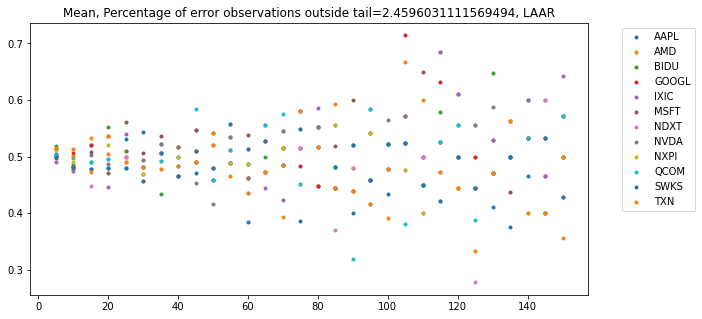

In [189]:
# Mean, LAAR, time window from 5 to 150, step size 5, tail e^0.9
plotdot_mean(meanLAAR, 5, 150, 5, math.e**0.9)

ticker      AAPL       AMD  BIDU  GOOGL      IXIC      MSFT  NDXT      NVDA  \
5       0.000000  0.009980   0.0    0.0  0.001996  0.000000   0.0  0.005988   
10      0.000000  0.008032   0.0    0.0  0.000000  0.004016   0.0  0.004016   
15      0.000000  0.006061   0.0    0.0  0.000000  0.000000   0.0  0.000000   
20      0.000000  0.008130   0.0    0.0  0.000000  0.000000   0.0  0.000000   
25      0.000000  0.000000   0.0    0.0  0.000000  0.010204   0.0  0.000000   
30      0.000000  0.012346   0.0    0.0  0.000000  0.000000   0.0  0.000000   
35      0.000000  0.000000   0.0    0.0  0.000000  0.000000   0.0  0.000000   
40      0.000000  0.000000   0.0    0.0  0.000000  0.000000   0.0  0.000000   
45      0.018868  0.000000   0.0    0.0  0.000000  0.000000   0.0  0.000000   
50      0.000000  0.000000   0.0    0.0  0.000000  0.020833   0.0  0.000000   
55      0.000000  0.000000   0.0    0.0  0.000000  0.000000   0.0  0.000000   
60      0.000000  0.000000   0.0    0.0  0.000000  0

(None,
 <AxesSubplot:title={'center':'Mean, Percentage of error observations outside tail=2.6881171418161212e+43, LAAR'}>)

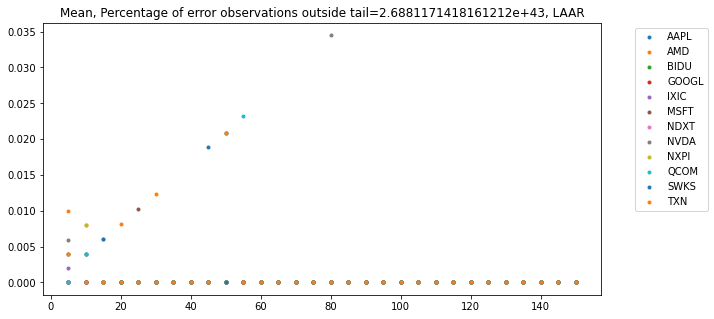

In [190]:
# Volatility, LAAR, time window from 5 to 150, step size 5, tail e^100
plotdot_mean(meanLAAR, 5, 150, 5, math.e**100)

ticker      AAPL       AMD      BIDU     GOOGL      IXIC      MSFT      NDXT  \
5       0.506986  0.499002  0.518962  0.512974  0.493014  0.497006  0.502994   
10      0.485944  0.518072  0.485944  0.518072  0.473896  0.481928  0.485944   
15      0.527273  0.533333  0.490909  0.521212  0.503030  0.509091  0.460606   
20      0.479675  0.512195  0.552846  0.544715  0.447154  0.479675  0.495935   
25      0.530612  0.510204  0.510204  0.510204  0.540816  0.561224  0.500000   
30      0.543210  0.456790  0.481481  0.469136  0.481481  0.506173  0.493827   
35      0.521739  0.492754  0.449275  0.507246  0.507246  0.550725  0.507246   
40      0.500000  0.516667  0.466667  0.500000  0.500000  0.516667  0.483333   
45      0.471698  0.509434  0.490566  0.490566  0.547170  0.547170  0.509434   
50      0.520833  0.520833  0.479167  0.458333  0.479167  0.541667  0.479167   
55      0.488372  0.558140  0.558140  0.511628  0.488372  0.488372  0.534884   
60      0.384615  0.461538  0.487179  0.

(None,
 <AxesSubplot:title={'center':'Mean, Percentage of error observations outside tail=3.7200759760208555e-44, LAAR'}>)

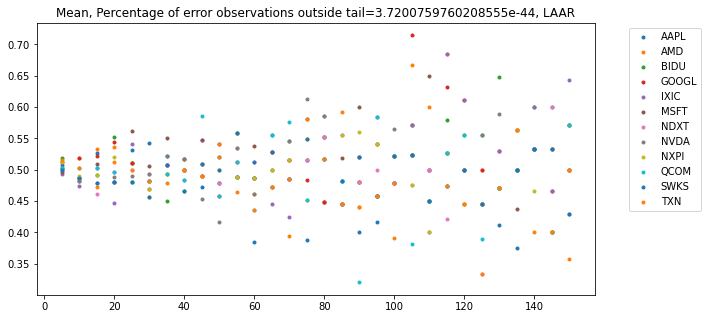

In [191]:
# Volatility, LAAR, time window from 5 to 150, step size 5, tail e^100
plotdot_mean(meanLAAR, 5, 150, 5, math.e**-100)